<a href="https://colab.research.google.com/github/shfiq1/CodingBook/blob/main/mobilenetv2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**import the important libraries**

In [ ]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
train_dir='/content/drive/MyDrive/images dataset/images/TRAIN'
test_dir='/content/drive/MyDrive/images dataset/images/TEST'

**Loading images**

In [ ]:
# Create generators

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 8162 images belonging to 4 classes.
Found 2038 images belonging to 4 classes.
Found 2488 images belonging to 4 classes.


**Build pretrained model**

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


**Build classification model**

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

**Training **

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
256/256 [==============================] - 2100s 8s/step - loss: 0.7968 - accuracy: 0.6723 - val_loss: 0.5960 - val_accuracy: 0.7601
Epoch 2/50
256/256 [==============================] - 41s 160ms/step - loss: 0.4655 - accuracy: 0.8201 - val_loss: 0.4282 - val_accuracy: 0.8371
Epoch 3/50
256/256 [==============================] - 38s 148ms/step - loss: 0.3376 - accuracy: 0.8731 - val_loss: 0.3945 - val_accuracy: 0.8405
Epoch 4/50
256/256 [==============================] - 37s 146ms/step - loss: 0.2730 - accuracy: 0.8999 - val_loss: 0.3015 - val_accuracy: 0.8837
Epoch 5/50
256/256 [==============================] - 39s 153ms/step - loss: 0.2126 - accuracy: 0.9233 - val_loss: 0.3299 - val_accuracy: 0.8616
Epoch 6/50
256/256 [==============================] - 38s 147ms/step - loss: 0.1697 - accuracy: 0.9436 - val_loss: 0.2710 - val_accuracy: 0.8965
Epoch 7/50
256/256 [==============================] - 39s 151ms/step - loss: 0.1495 - accuracy: 0.9507 - val_loss: 0.2284 - val_acc

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

**Results**

In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

78/78 [==============================] - 668s 9s/step
Test Accuracy: 51.809%


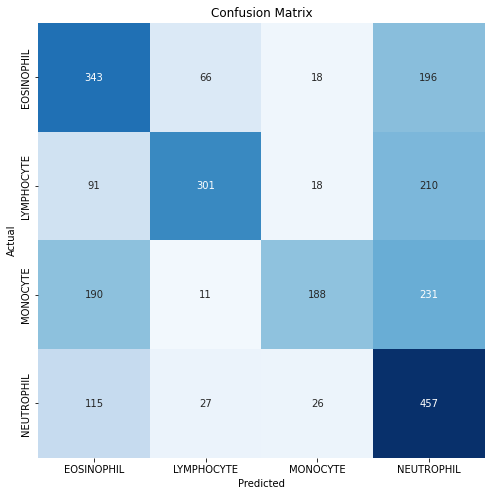

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.46      0.55      0.50       623
  LYMPHOCYTE       0.74      0.49      0.59       620
    MONOCYTE       0.75      0.30      0.43       620
  NEUTROPHIL       0.42      0.73      0.53       625

    accuracy                           0.52      2488
   macro avg       0.59      0.52      0.51      2488
weighted avg       0.59      0.52      0.51      2488



In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Found 2038 images belonging to 4 classes.
64/64 [==============================] - 8s 124ms/step
Validation Accuracy: 92.983%


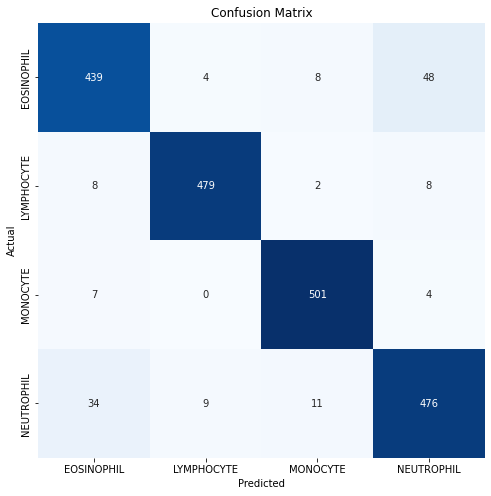

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.90      0.88      0.89       499
  LYMPHOCYTE       0.97      0.96      0.97       497
    MONOCYTE       0.96      0.98      0.97       512
  NEUTROPHIL       0.89      0.90      0.89       530

    accuracy                           0.93      2038
   macro avg       0.93      0.93      0.93      2038
weighted avg       0.93      0.93      0.93      2038



In [ ]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


predictions = np.argmax(model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)